In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score # Using F1 score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
import all_metrics as all_metrics # Assuming your custom metrics function is available
import credit_card_fraud_utils as ccf


In [2]:
config = ccf.Config()
# Load the dataset
df = ccf.load_data(config)

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(f"Number of Transactions: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")

# Display the first few rows
df.head()

Dataset Shape: (284807, 31)
Number of Transactions: 284807
Number of Features: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [4]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()), # Keep scaling
    ('resampler', None),          # Placeholder
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_jobs=-1 # Use all cores for RF too
    ))
])

In [5]:

rf_param_ranges = {
    'classifier__n_estimators': [100, 200, 300, 400, 500], # Number of trees
    'classifier__max_depth': [10, 20, 30, None], # Deeper trees often okay for RF; None means no limit until leaves are pure or min_samples hit
    'classifier__max_features': ['sqrt', 'log2', 0.3], # Number of features per split ('sqrt' is common)
    'classifier__min_samples_split': [2, 5, 10], # Min samples to split node
    'classifier__min_samples_leaf': [1, 3, 5],    # Min samples per leaf
    'classifier__bootstrap': [True] # Usually True for RF
    # 'classifier__criterion': ['gini', 'entropy'] # Can also test split criterion
}

# Resampler parameters (same as before)
smote_k_neighbors = [3, 5, 10]
adasyn_n_neighbors = [3, 5, 10]
rus_sampling_strategy = [0.2, 0.35, 0.5]
ros_sampling_strategy = [0.5, 0.7, 1.0]

param_grid_rf = []

# --- Configuration for NO Resampling (Test RF's internal weighting) ---
param_grid_rf.append({
    'resampler': [None],
    **rf_param_ranges,
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample'] # RF's way to handle imbalance
})


# --- Configurations for Resampling Methods --
resampling_options_list = [
    {'resampler': [SMOTE(random_state=42)], 'resampler__k_neighbors': smote_k_neighbors},
    {'resampler': [ADASYN(random_state=42)], 'resampler__n_neighbors': adasyn_n_neighbors},
    {'resampler': [RandomOverSampler(random_state=42)], 'resampler__sampling_strategy': ros_sampling_strategy},
    {'resampler': [RandomUnderSampler(random_state=42)], 'resampler__sampling_strategy': rus_sampling_strategy},
    {'resampler': [TomekLinks(sampling_strategy='auto')]},
    {'resampler': [NearMiss(version=1)]}
]

# --- Configurations for Resampling Methods (Turn off internal weighting) ---

for resampler_config in resampling_options_list:
    config = {
        **resampler_config,
        **rf_param_ranges,
        'classifier__class_weight': [None] # Use None when external resampling is active
    }
    param_grid_rf.append(config)

In [8]:
n_iterations_rf = 75 # Or adjust as needed
scoring_metric = 'f1'
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=n_iterations_rf,
    scoring=scoring_metric,
    refit=scoring_metric,
    cv=cv_strategy,
    verbose=1, # Show progress
    n_jobs=-1, # Use all cores
    random_state=42
)

print(f"\nStarting RandomizedSearchCV for RandomForest with n_iter={n_iterations_rf}...")
random_search_rf.fit(X_train, y_train) # Uncomment to run


Starting RandomizedSearchCV for RandomForest with n_iter=75...
Fitting 5 folds for each of 75 candidates, totalling 375 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('resampler', None),
                                             ('classifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions=[{'classifier__bootstrap': [True],
                                         'classifier__class_weight': [None,
                                                                      'balanced',
                                                                      'balanced_subs...
                                        {'classifier__bootstrap': [True],
                                         'classifier__class_weight': [None],
                                         'classifier__max_depth': [10, 20, 30,
                                                                   None],
                                         'classifier__max_features': ['sqrt',
                                                                      'log2',
                                                                      0.3],
                                         'classifier__min_samples_leaf': [1, 3,
                                                                          5],
                                         'classifier__min_samples_split': [2, 5,
                                                                           10],
                                         'classifier__n_estimators': [100, 200,
                                                                      300, 400,
                                                                      500],
                                         'resampler': [NearMiss()]}],
                   random_state=42, refit='f1', scoring='f1', verbose=1)

In [9]:

print("\nBest Random Forest Parameters Found:")
print(random_search_rf.best_params_)
print("\nBest CV " + scoring_metric.upper() + " Score:")
print(random_search_rf.best_score_)


Best Random Forest Parameters Found:
{'resampler__sampling_strategy': 0.7, 'resampler': RandomOverSampler(random_state=42), 'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 3, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 30, 'classifier__class_weight': None, 'classifier__bootstrap': True}

Best CV F1 Score:
0.8556325149342255


In [10]:

best_pipeline_rf = random_search_rf.best_estimator_
results_rf = all_metrics.calculate_model_metrics(
    best_pipeline_rf, X_test, y_test, 'Random Forest (RandomizedSearch Best)'
)



Metrics for Random Forest (RandomizedSearch Best):
Accuracy: 0.9996
Precision: 0.9405
Recall: 0.8061
F1-score: 0.8681
AUPRC: 0.8823
AUROC: 0.9719
Recall at 0.5% FPR: 0.8878
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.8705
Kolmogorov-Smirnov Statistic: 0.9091
Confusion Matrix:
[[56859     5]
 [   19    79]]


In [12]:

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical



pipeline_rf_bayes = Pipeline([
    ('scaler', StandardScaler()),
    ('resampler', None),          # Placeholder
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])



# Best values found: n_estimators=200, max_depth=30, max_features='sqrt', min_samples_split=5, min_samples_leaf=3
search_spaces_rf_bayes = {
    # --- Fix the winning configuration ---
    'resampler': Categorical([RandomOverSampler(sampling_strategy=0.7, random_state=42)]),
    
  

    'classifier__class_weight': Categorical([None]), # Fixed
    'classifier__bootstrap': Categorical([True]),    # Fixed

    # --- Tune RF Parameters around best values ---
    'classifier__n_estimators': Integer(150, 400, prior='uniform'),      # Explore around 200
    'classifier__max_depth': Integer(20, 45, prior='uniform'),         # Explore around 30, allow deeper
    'classifier__max_features': Categorical(['sqrt', 'log2']),         # Best was 'sqrt', test 'log2' too
    'classifier__min_samples_split': Integer(3, 10, prior='uniform'),   # Explore around 5
    'classifier__min_samples_leaf': Integer(1, 5, prior='uniform'),     # Explore around 3
}

n_iterations_rf_bayes = 10 # Number of iterations for Bayesian optimization
scoring_metric = 'f1'
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_search_rf = BayesSearchCV(
    estimator=pipeline_rf_bayes, # Use the pipeline defined for BayesSearch
    search_spaces=search_spaces_rf_bayes,
    n_iter=n_iterations_rf_bayes,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=1
)


print(f"\nStarting BayesSearchCV for RandomForest with n_iter={n_iterations_rf_bayes}...")
print(f"Using focused search space based on RandomizedSearch results:")
print(f"  Resampler: RandomOverSampler(sampling_strategy=0.7)")
print(f"  Class Weight: None")




Starting BayesSearchCV for RandomForest with n_iter=10...
Using focused search space based on RandomizedSearch results:
  Resampler: RandomOverSampler(sampling_strategy=0.7)
  Class Weight: None


In [13]:

bayes_search_rf.fit(X_train, y_train) # Uncomment to run



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('resampler', None),
                                        ('classifier',
                                         RandomForestClassifier(n_jobs=-1,
                                                                random_state=42))]),
              n_iter=10, n_jobs=-1, random_state=42, scoring='f1',
              search_spaces={'classifier__bootstrap': Categorical(categories=(True,), prior=None),
                             'clas...
                             'classifier__min_samples_leaf': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'classifier__min_samples_split': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'classifier__n_estimators': Integer(low=150, high=400, prior='uniform', transform='normalize'),
                             'resampler': Categorical(categories=(RandomOverSampler(random_state=42, sampling_strategy=0.7),), prior=None)},
              verbose=1)

In [14]:

print("\nBest RandomForest Parameters Found (BayesSearchCV):")
best_params_rf_bayes = dict(bayes_search_rf.best_params_) # Convert OrderedDict if needed
print(best_params_rf_bayes)
print("\nBest CV " + scoring_metric.upper() + " Score (BayesSearchCV):")
print(bayes_search_rf.best_score_)



Best RandomForest Parameters Found (BayesSearchCV):
{'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__max_depth': 39, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 228, 'resampler': RandomOverSampler(random_state=42, sampling_strategy=0.7)}

Best CV F1 Score (BayesSearchCV):
0.8556325149342255


In [15]:


print("\n--- Evaluating Best RandomForest Model from BayesSearch on Test Set ---")
best_pipeline_rf_bayes = bayes_search_rf.best_estimator_
results_rf_bayes = all_metrics.calculate_model_metrics(
    best_pipeline_rf_bayes, X_test, y_test, 'RandomForest (BayesSearch Best)'
)



--- Evaluating Best RandomForest Model from BayesSearch on Test Set ---

Metrics for RandomForest (BayesSearch Best):
Accuracy: 0.9996
Precision: 0.9518
Recall: 0.8061
F1-score: 0.8729
AUPRC: 0.8834
AUROC: 0.9720
Recall at 0.5% FPR: 0.8878
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.8757
Kolmogorov-Smirnov Statistic: 0.9229
Confusion Matrix:
[[56860     4]
 [   19    79]]


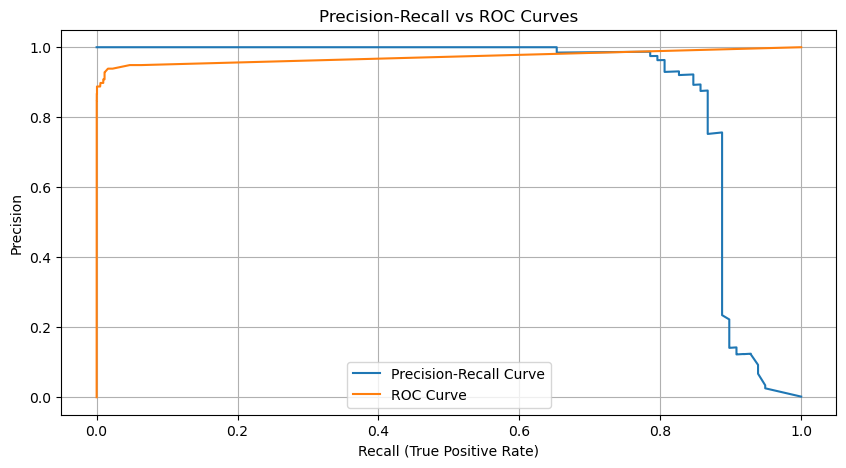

In [16]:
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

# Get anomaly scores (the lower the score, the more likely it's an outlier)
y_scores_rf = best_pipeline_rf_bayes.predict_proba(X_test)[:, 1]  # Probability of positive class

# Get binary predictions for metrics
y_pred_rf = best_pipeline_rf_bayes.predict(X_test)

# Calculate precision-recall curve
precision_rf, recall_rf, thresholds_pr = precision_recall_curve(y_test, y_scores_rf)

# Calculate ROC curve
fpr_rf, tpr_rf, thresholds_roc = roc_curve(y_test, y_scores_rf)

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall_rf, precision_rf, label='Precision-Recall Curve')
plt.plot(fpr_rf, tpr_rf, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

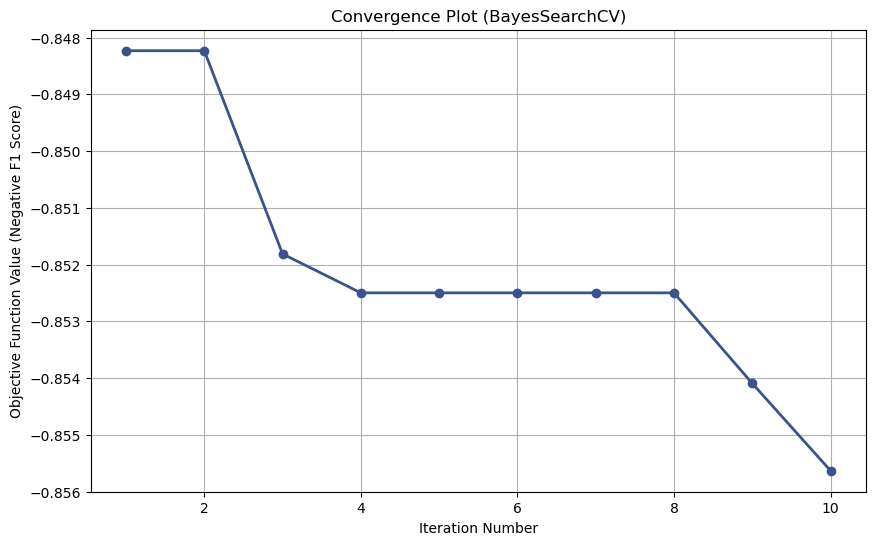

In [17]:
from skopt.plots import plot_convergence
optimize_result = bayes_search_rf.optimizer_results_[0]

plt.figure(figsize=(10, 6)) # Optional: Adjust figure size
plot_convergence(optimize_result)
plt.title('Convergence Plot (BayesSearchCV)')
plt.ylabel('Objective Function Value (Negative F1 Score)') # Adjust label if needed
plt.xlabel('Iteration Number')
plt.grid(True)
plt.show()

More iterations might slightly improve the model performance, but with the random forrest classifier it is computationally much more expensive.